## Importing Packages and Data File

In [1]:
import pandas as pd      #Panel Data Analysis
import numpy as np       #Numerical Python

import seaborn as sns              
import matplotlib.pyplot as plt #Data Visualization and EDA
%matplotlib inline

import time             
from datetime import datetime  #Reading and Manipulation of Date and Time

from sklearn.preprocessing import StandardScaler
'''
Rescaling features so that they will have the properties of a Standard Normal Distribution

'''

from sklearn.model_selection import train_test_split,RandomizedSearchCV
'''
Train test Split: Splitting data random train and test subsets
RandomizedSearchCV: Optimizing parameter values for an estimator

'''
from sklearn import metrics  #quantifying the quality of our predictions
from sklearn.metrics import mean_squared_error #average of the squares of the errors or deviations

from sklearn.linear_model import LinearRegression #Linear Regression

from sklearn import ensemble #GradientBoostingRegressor


In [2]:
df = pd.read_csv("C:/Users/USER/Documents/Smart_City/bus_data.csv", index_col = 'bus_id')

df.head()

,pickup_datetime,dropoff_datetime,holiday,day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_zip,pickup_location,dropoff_zip,dropoff_location
bus_id,,,,,,,,,,,,
1,01-01-2017 10:18,01-01-2017 10:53,1,Sunday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur
2,02-01-2017 21:20,02-01-2017 22:00,0,Monday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur
3,03-01-2017 14:10,03-01-2017 14:50,0,Tuesday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur
4,04-01-2017 17:15,04-01-2017 17:58,0,Wednesday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur
5,05-01-2017 15:00,05-01-2017 15:40,0,Thursday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur


## Data Preprocessing

##### Understanding the data types


In [3]:
df.dtypes

pickup_datetime       object
dropoff_datetime      object
holiday                int64
day                   object
pickup_latitude      float64
pickup_longitude     float64
dropoff_latitude     float64
dropoff_longitude    float64
pickup_zip             int64
pickup_location       object
dropoff_zip            int64
dropoff_location      object
dtype: object

##### Converting objects to datetime format


In [4]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

##### Extracting the distance from the coordinates


In [5]:
from math import sin, cos, sqrt, atan2, radians

def distance_bw_pickup_drop(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude):
    R = 6373.0
    dlon = dropoff_longitude - pickup_longitude
    dlat = dropoff_latitude - pickup_latitude
    a = sin(dlat / 2)**2 + cos(pickup_latitude) * cos(dropoff_latitude) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [6]:
df['trip_distance'] = df.apply(lambda row: distance_bw_pickup_drop(radians(row.pickup_latitude),radians(row.pickup_longitude), radians(row.dropoff_latitude), radians(row.dropoff_longitude) ), axis=1)

##### Extracting the trip duration from the pickup datetime and drop datetime


In [7]:
df['trip_duration'] = df['dropoff_datetime'] - df['pickup_datetime']

'''
converting the time dtype to integer dtype and converting the units to seconds

'''

df['trip_duration'] = df['trip_duration'].apply(lambda x: x.seconds) 

##### Extracting only the hour from the pickup datetime which is an important feature

In [8]:
df['hour_of_day'] = df.pickup_datetime.apply(lambda x: x.hour)

## Data After Preprocessing

In [9]:
df.dtypes

pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
holiday                       int64
day                          object
pickup_latitude             float64
pickup_longitude            float64
dropoff_latitude            float64
dropoff_longitude           float64
pickup_zip                    int64
pickup_location              object
dropoff_zip                   int64
dropoff_location             object
trip_distance               float64
trip_duration                 int64
hour_of_day                   int64
dtype: object

In [10]:
df.head()

,pickup_datetime,dropoff_datetime,holiday,day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_zip,pickup_location,dropoff_zip,dropoff_location,trip_distance,trip_duration,hour_of_day
bus_id,,,,,,,,,,,,,,,
1,2017-01-01 10:18:00,2017-01-01 10:53:00,1,Sunday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur,7.528195,2100,10
2,2017-02-01 21:20:00,2017-02-01 22:00:00,0,Monday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur,7.528195,2400,21
3,2017-03-01 14:10:00,2017-03-01 14:50:00,0,Tuesday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur,7.528195,2400,14
4,2017-04-01 17:15:00,2017-04-01 17:58:00,0,Wednesday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur,7.528195,2580,17
5,2017-05-01 15:00:00,2017-05-01 15:40:00,0,Thursday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,641005,Singanallur,7.528195,2400,15


## Exploratory Data Analysis

##### Selecting the variables for our analysis

In [11]:
features = ['holiday', 'day', 'dropoff_location', 'trip_distance', 'hour_of_day', 'trip_duration']

##### Deriving basic statistics of all variables

In [12]:
df[features].describe(include='all') #Looking for Null values if any

,holiday,day,dropoff_location,trip_distance,hour_of_day,trip_duration
count,521.000000,521,521,521.000000,521.000000,521.000000
unique,NaN,7,4,NaN,NaN,NaN
top,NaN,Saturday,Railway,NaN,NaN,NaN
freq,NaN,92,248,NaN,NaN,NaN
mean,0.067179,NaN,NaN,5.154956,14.383877,1714.318618
std,0.250571,NaN,NaN,2.355076,5.456687,599.524143
min,0.000000,NaN,NaN,2.687554,5.000000,720.000000
25%,0.000000,NaN,NaN,2.687554,9.000000,1260.000000
50%,0.000000,NaN,NaN,7.287752,15.000000,1500.000000
75%,0.000000,NaN,NaN,7.367980,19.000000,2160.000000


##### Correlation Matrix

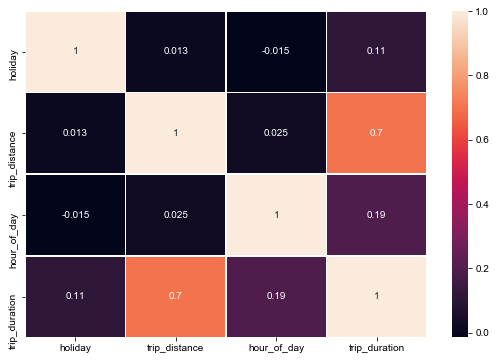

In [13]:
corr = df[features].corr()
corr

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)
sns.set()

##### Scaterplot - Duration vs Distance

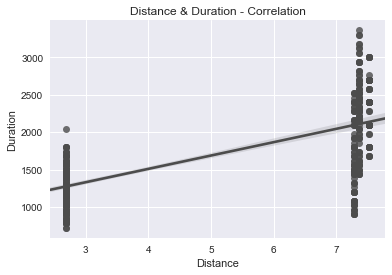

In [14]:
c = sns.regplot(x='trip_distance', y='trip_duration', data=df, color='.3')
c = plt.title('Distance & Duration - Correlation')
c = plt.xlabel('Distance')
c = plt.ylabel('Duration')
c = sns.set(font_scale=1.3)
plt.show()

##### HeatMap - Hours of the day
### Which are the busiest hours of the day? 

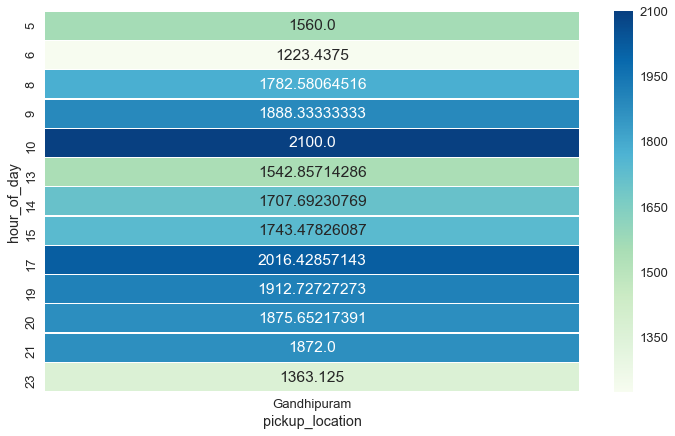

In [15]:
table = pd.pivot_table(df, values='trip_duration', index='hour_of_day', columns='pickup_location' ,aggfunc = np.mean)
table = table.dropna()
fig, ax= plt.subplots(figsize=(12,7))
sns.heatmap(table, fmt="", annot=True, cmap='GnBu', linewidths = 0.30, ax=ax)

##### HeatMap - Days of the week
### Which are the busiest days of the week? 

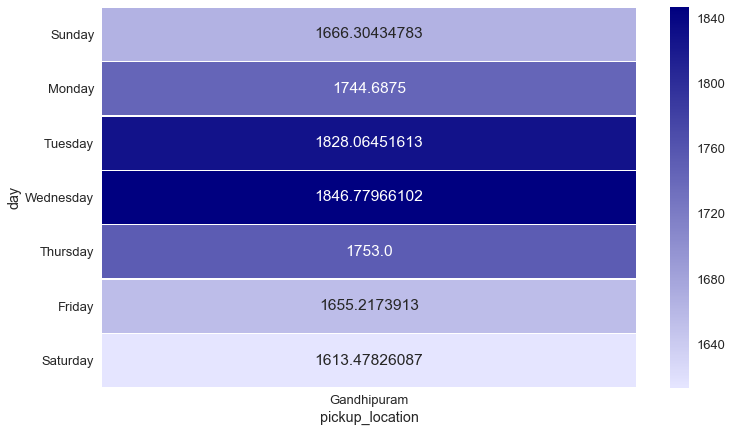

In [16]:
table = pd.pivot_table(df, values='trip_duration', index='day', columns='pickup_location' ,aggfunc = np.mean)
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
table = table.reindex(days)
table = table.dropna()
fig, ax= plt.subplots(figsize=(12,7))
sns.heatmap(table, fmt="", annot=True, cmap=sns.light_palette("Navy", as_cmap=True), linewidths = 0.30, ax=ax)

##### Holiday vs Normal Day

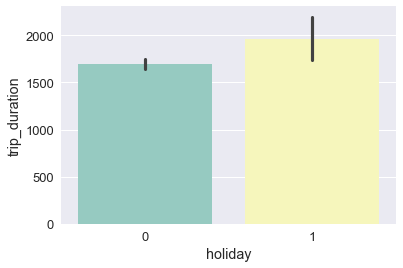

In [17]:
ax = sns.barplot(x="holiday", y="trip_duration",  data= df, palette="Set3")

## Handling Categorical Features
#### Dummy encoding

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

In [18]:
day_of_week_dummies = pd.get_dummies(df.day, prefix='day_of_week')

hour_of_day_dummies = pd.get_dummies(df.hour_of_day, prefix='hour_of_day')

dropoff_dummies = pd.get_dummies(df.dropoff_location, prefix='dropoff')

In [19]:
df = pd.concat([df, hour_of_day_dummies, day_of_week_dummies, dropoff_dummies ], axis=1)
df.head()

,pickup_datetime,dropoff_datetime,holiday,day,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_zip,pickup_location,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,dropoff_Railway,dropoff_Saravanampatti,dropoff_Singanallur,dropoff_Thudiyalur
bus_id,,,,,,,,,,,,,,,,,,,,,
1,2017-01-01 10:18:00,2017-01-01 10:53:00,1,Sunday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,...,0,0,1,0,0,0,0,0,1,0
2,2017-02-01 21:20:00,2017-02-01 22:00:00,0,Monday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,...,1,0,0,0,0,0,0,0,1,0
3,2017-03-01 14:10:00,2017-03-01 14:50:00,0,Tuesday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,...,0,0,0,0,1,0,0,0,1,0
4,2017-04-01 17:15:00,2017-04-01 17:58:00,0,Wednesday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,...,0,0,0,0,0,1,0,0,1,0
5,2017-05-01 15:00:00,2017-05-01 15:40:00,0,Thursday,11.020522,76.966698,10.998735,77.031978,641012,Gandhipuram,...,0,0,0,1,0,0,0,0,1,0


In [20]:
feature_cols = ['hour_of_day_5', 'hour_of_day_6', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
       'hour_of_day_13', 'hour_of_day_14', 'hour_of_day_15',
       'hour_of_day_17', 'hour_of_day_19', 'hour_of_day_20',
       'hour_of_day_21', 'hour_of_day_23', 'day_of_week_Sunday',
       'day_of_week_Monday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday',
       'dropoff_Singanallur', 'dropoff_Thudiyalur',
       'dropoff_Saravanampatti','dropoff_Railway', 'holiday', 'trip_distance']

## Fitting a Linear Regression Model

In [21]:
X = df[feature_cols]
y = df.trip_duration
X_train,X_test,y_train,y_test=train_test_split(X, y, random_state=3)

In [22]:
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
linreg = lm.fit(X_train, y_train)

#### R2 determines how well the regression line approximates the real data points

In [24]:
rtest = np.round(lm.score(X_test, y_test)*100,0)
rtrain = np.round(lm.score(X_train, y_train)*100,0)

print("RSquare Value for test data is: %.2f" % rtest)
print("RSquare Value for train data is: %.2f" % rtrain)

RSquare Value for test data is: 75.00
RSquare Value for train data is: 81.00


## Evaluation Metrics for Regression


**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [25]:
from sklearn import metrics

def train_test_rmse(feature_cols):
    X = df[feature_cols]
    y = df.trip_duration
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [28]:
rmse = (train_test_rmse(['hour_of_day_5', 'hour_of_day_6', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
       'hour_of_day_13', 'hour_of_day_14', 'hour_of_day_15',
       'hour_of_day_17', 'hour_of_day_19', 'hour_of_day_20',
       'hour_of_day_21', 'hour_of_day_23', 'day_of_week_Sunday',
       'day_of_week_Monday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday',
       'dropoff_Singanallur', 'dropoff_Thudiyalur',
       'dropoff_Saravanampatti','dropoff_Railway', 'holiday', 'trip_distance']))

rmse = rmse/60

In [29]:
print("RMSE Value for linear regression model is: %.2f" % rmse) # when converted to minutes

RMSE Value for linear regression model is: 4.27


## Why are we not using Linear Regression?

Pros:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations

Cons:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning

## Using Ensemble Method - Gradient Boosting

#### Parameter Tuning - Grid Search

In [36]:
from sklearn.utils import shuffle
GBmodel = ensemble.GradientBoostingRegressor()
param_dist = {'n_estimators':(250, 300, 500), "learning_rate": np.linspace(0.05, 0.15,5),
               "max_depth": range(3, 5),
               "min_samples_leaf": range(3, 5)}

rand = RandomizedSearchCV(GBmodel, param_dist, cv=7,n_iter=10, random_state=5)
rand.fit(X,y)
rand.grid_scores_

print(rand.best_score_)
print(rand.best_params_)

0.753286588061
{'n_estimators': 300, 'learning_rate': 0.10000000000000001, 'max_depth': 4, 'min_samples_leaf': 3}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### Model Fitting

In [40]:
params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(**params)

gbr.fit(X_train, y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

#### Evaluation

In [41]:
mse = mean_squared_error(y_test, gbr.predict(X_test))
rmse = np.sqrt(mse)
rmse = rmse/60
print("RMSE using Gradient Boosting Regressor is: %.2f" % rmse)

RMSE using Gradient Boosting Regressor is: 3.77


In [42]:
rtest = np.round(gbr.score(X_test, y_test)*100,0)
print("RSquare Value for test data is: %.2f" % rtest)
rtrain = np.round(gbr.score(X_train, y_train)*100,0)
print("RSquare Value for train data is: %.2f" % rtrain)

RSquare Value for test data is: 84.00
RSquare Value for train data is: 92.00


#### Feature Importance

Text(0.5,1,'Feature Importances - Regression')

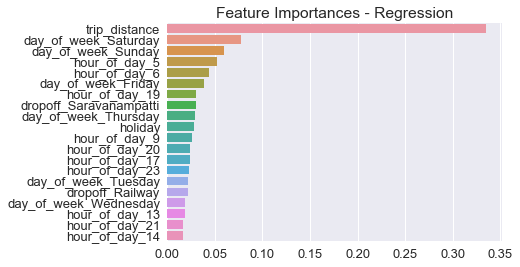

In [44]:
importances = gbr.feature_importances_
importances_by_trees=[tree[0].feature_importances_ for tree in gbr.estimators_]
std = np.std(importances_by_trees,axis=0)
indices = np.argsort(importances)[::-1]

dff = df[feature_cols]
sns.barplot(importances[indices][:20],dff.columns[indices[:20]].values)
plt.title("Feature Importances - Regression")